## 1. Install Required Libraries

In [64]:
# Install XGBoost if not already installed
!pip install xgboost scikit-learn pandas numpy matplotlib seaborn

## 2. Import Libraries

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [66]:
def generate_stress_data(n_samples=5000):
    """
    Generate synthetic stress detection dataset with continuous stress scores (0-100)
    """
    data = []

    for _ in range(n_samples):
        # Generate base features
        age = np.random.randint(18, 65)
        gender = np.random.choice(['Male', 'Female'])
        exercise_level = np.random.choice(['Low', 'Medium', 'High'])
        sleep_hours = np.random.uniform(4, 10)
        work_hours = np.random.uniform(20, 80)

        # Calculate stress score based on features (0-100 scale)
        stress_score = 0

        # Work hours contribution (0-35 points)
        # Linear relationship: more work hours = more stress
        work_stress = ((work_hours - 20) / (80 - 20)) * 35
        stress_score += work_stress

        # Sleep hours contribution (0-30 points)
        # Inverse relationship: less sleep = more stress
        sleep_stress = ((10 - sleep_hours) / (10 - 4)) * 30
        stress_score += sleep_stress

        # Exercise level contribution (0-20 points)
        if exercise_level == 'Low':
            stress_score += 20
        elif exercise_level == 'Medium':
            stress_score += 10
        else:
            stress_score += 3

        # Age contribution (0-15 points)
        # Peak stress in middle age (35-50)
        if 35 <= age <= 50:
            age_stress = 15
        elif age > 50:
            age_stress = 10
        else:
            age_stress = 8
        stress_score += age_stress

        # Add random noise for variability
        stress_score += np.random.uniform(-8, 8)

        # Ensure score is within 0-100 range
        stress_score = np.clip(stress_score, 0, 100)
        stress_score = round(stress_score, 2)

        data.append({
            'Age': age,
            'Gender': gender,
            'Exercise Level': exercise_level,
            'Sleep Hours': round(sleep_hours, 1),
            'Work Hours per Week': round(work_hours, 1),
            'Stress Score': stress_score
        })

    return pd.DataFrame(data)

# Generate dataset
print("Generating synthetic stress detection data...\n")
df = generate_stress_data(n_samples=5000)
print(f"Dataset created with {len(df)} samples")
print("\nFirst few rows:")
print(df.head(10))
print(f"\nStress Score Range: {df['Stress Score'].min():.2f} - {df['Stress Score'].max():.2f}")
print(f"Mean Stress Score: {df['Stress Score'].mean():.2f}")
print(f"Median Stress Score: {df['Stress Score'].median():.2f}")

Generating synthetic stress detection data...

Dataset created with 5000 samples

First few rows:
   Age  Gender Exercise Level  Sleep Hours  Work Hours per Week  Stress Score
0   56  Female            Low          5.1                 66.8         83.34
1   36    Male           High          6.8                 40.0         40.19
2   20  Female            Low          9.8                 69.9         53.44
3   38    Male         Medium          7.1                 45.9         51.04
4   59  Female           High          6.7                 67.1         51.99
5   20    Male           High          8.1                 47.0         28.57
6   42  Female         Medium          8.9                 38.3         34.97
7   37  Female           High          8.1                 56.6         54.18
8   52  Female            Low          5.6                 59.8         72.41
9   23  Female         Medium          7.4                 21.9         37.54

Stress Score Range: 8.74 - 100.00
Mean Stre

## 4. Exploratory Data Analysis

In [67]:
# Display basic statistics
print("Dataset Info:")
print(df.info())
print("\nDataset Description:")
print(df.describe())
print("\nStress Score Statistics:")
print(f"Min: {df['Stress Score'].min():.2f}")
print(f"Max: {df['Stress Score'].max():.2f}")
print(f"Mean: {df['Stress Score'].mean():.2f}")
print(f"Median: {df['Stress Score'].median():.2f}")
print(f"Std Dev: {df['Stress Score'].std():.2f}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  5000 non-null   int64  
 1   Gender               5000 non-null   object 
 2   Exercise Level       5000 non-null   object 
 3   Sleep Hours          5000 non-null   float64
 4   Work Hours per Week  5000 non-null   float64
 5   Stress Score         5000 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 234.5+ KB
None

Dataset Description:
               Age  Sleep Hours  Work Hours per Week  Stress Score
count  5000.000000  5000.000000          5000.000000   5000.000000
mean     40.791600     7.007540            49.645580     54.281842
std      13.603072     1.731781            17.243582     15.872612
min      18.000000     4.000000            20.000000      8.740000
25%      29.000000     5.500000            34.800000  

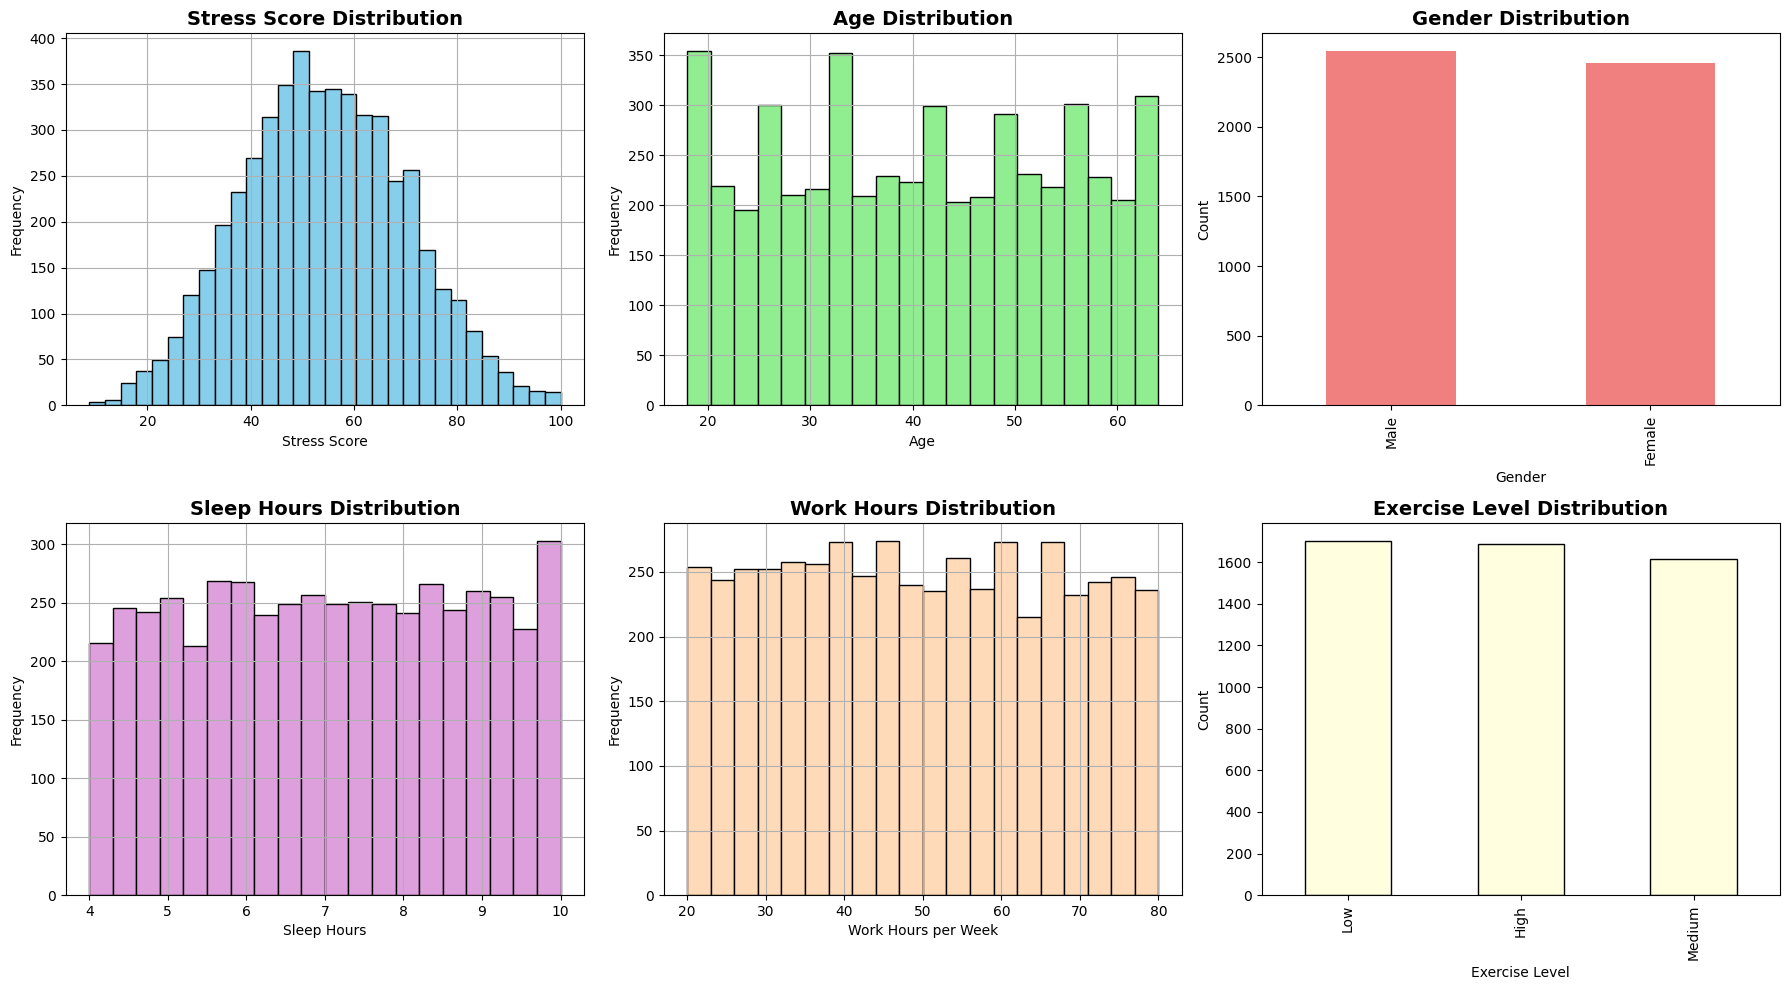

In [68]:
# Visualize stress score distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Stress score distribution
df['Stress Score'].hist(bins=30, ax=axes[0, 0], color='skyblue', edgecolor='black')
axes[0, 0].set_title('Stress Score Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Stress Score')
axes[0, 0].set_ylabel('Frequency')

# Age distribution
df['Age'].hist(bins=20, ax=axes[0, 1], color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Age Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Frequency')

# Gender distribution
df['Gender'].value_counts().plot(kind='bar', ax=axes[0, 2], color='lightcoral')
axes[0, 2].set_title('Gender Distribution', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Gender')
axes[0, 2].set_ylabel('Count')

# Sleep hours distribution
df['Sleep Hours'].hist(bins=20, ax=axes[1, 0], color='plum', edgecolor='black')
axes[1, 0].set_title('Sleep Hours Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Sleep Hours')
axes[1, 0].set_ylabel('Frequency')

# Work hours distribution
df['Work Hours per Week'].hist(bins=20, ax=axes[1, 1], color='peachpuff', edgecolor='black')
axes[1, 1].set_title('Work Hours Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Work Hours per Week')
axes[1, 1].set_ylabel('Frequency')

# Exercise level distribution
df['Exercise Level'].value_counts().plot(kind='bar', ax=axes[1, 2], color='lightyellow', edgecolor='black')
axes[1, 2].set_title('Exercise Level Distribution', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Exercise Level')
axes[1, 2].set_ylabel('Count')

plt.tight_layout()
plt.show()

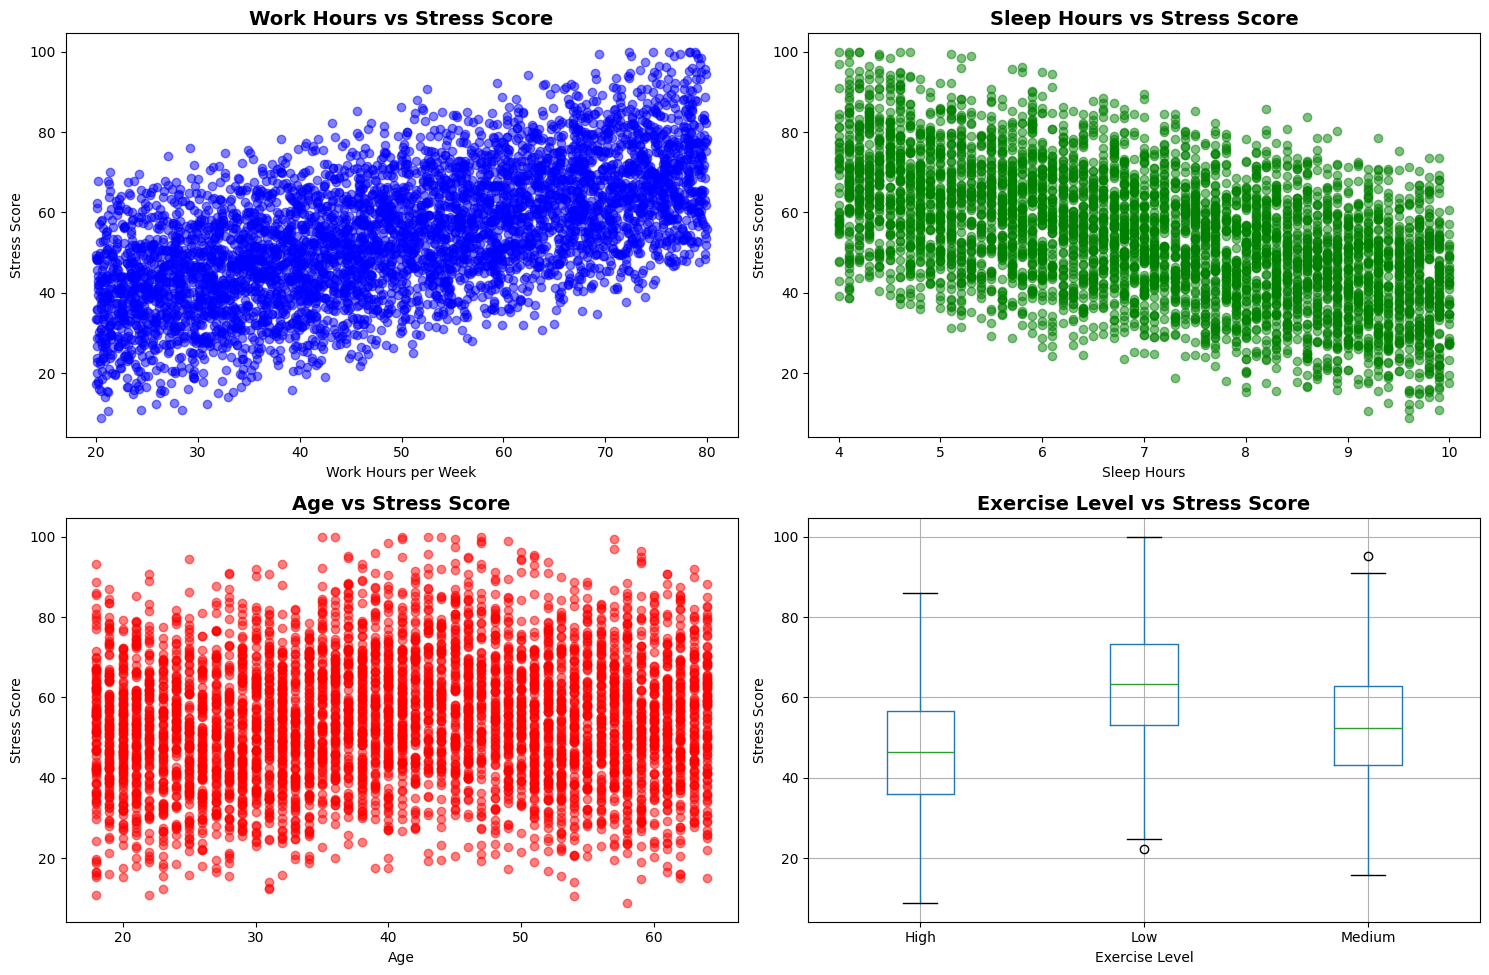

In [69]:
# Visualize relationships with stress score
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Work hours vs Stress Score
axes[0, 0].scatter(df['Work Hours per Week'], df['Stress Score'], alpha=0.5, color='blue')
axes[0, 0].set_title('Work Hours vs Stress Score', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Work Hours per Week')
axes[0, 0].set_ylabel('Stress Score')

# Sleep hours vs Stress Score
axes[0, 1].scatter(df['Sleep Hours'], df['Stress Score'], alpha=0.5, color='green')
axes[0, 1].set_title('Sleep Hours vs Stress Score', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Sleep Hours')
axes[0, 1].set_ylabel('Stress Score')

# Age vs Stress Score
axes[1, 0].scatter(df['Age'], df['Stress Score'], alpha=0.5, color='red')
axes[1, 0].set_title('Age vs Stress Score', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Stress Score')

# Exercise level vs Stress Score (boxplot)
df.boxplot(column='Stress Score', by='Exercise Level', ax=axes[1, 1])
axes[1, 1].set_title('Exercise Level vs Stress Score', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Exercise Level')
axes[1, 1].set_ylabel('Stress Score')
plt.suptitle('')  # Remove the default title

plt.tight_layout()
plt.show()

## 5. Data Preprocessing

In [70]:
# Separate features and target
X = df.drop('Stress Score', axis=1)
y = df['Stress Score']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature columns:", X.columns.tolist())
print(f"\nTarget range: {y.min():.2f} - {y.max():.2f}")

Features shape: (5000, 5)
Target shape: (5000,)

Feature columns: ['Age', 'Gender', 'Exercise Level', 'Sleep Hours', 'Work Hours per Week']

Target range: 8.74 - 100.00


In [71]:
# Split data into train and test sets (no stratify for regression)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print("\nTraining set stress score statistics:")
print(f"  Mean: {y_train.mean():.2f}")
print(f"  Min: {y_train.min():.2f}")
print(f"  Max: {y_train.max():.2f}")
print("\nTest set stress score statistics:")
print(f"  Mean: {y_test.mean():.2f}")
print(f"  Min: {y_test.min():.2f}")
print(f"  Max: {y_test.max():.2f}")

Training set size: 4000
Test set size: 1000

Training set stress score statistics:
  Mean: 54.35
  Min: 8.74
  Max: 100.00

Test set stress score statistics:
  Mean: 54.03
  Min: 13.96
  Max: 100.00


In [72]:
# Define preprocessing pipeline
# Categorical columns: Gender, Exercise Level
# Numerical columns: Age, Sleep Hours, Work Hours per Week

categorical_features = ['Gender', 'Exercise Level']
numerical_features = ['Age', 'Sleep Hours', 'Work Hours per Week']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

print("Preprocessing pipeline created successfully!")
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

Preprocessing pipeline created successfully!
Numerical features: ['Age', 'Sleep Hours', 'Work Hours per Week']
Categorical features: ['Gender', 'Exercise Level']


## 6. Train Random Forest Model

In [73]:
# Create Random Forest Regressor pipeline
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_estimators=100))
])

print("Training Random Forest Regressor model...")
rf_pipeline.fit(X_train, y_train)
print("Random Forest model trained successfully!")

# Make predictions
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluate model with regression metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"\nRandom Forest Regression Metrics:")
print(f"  Mean Absolute Error (MAE): {rf_mae:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rf_rmse:.4f}")
print(f"  R² Score: {rf_r2:.4f}")

Training Random Forest Regressor model...
Random Forest model trained successfully!

Random Forest Regression Metrics:
  Mean Absolute Error (MAE): 4.3442
  Root Mean Squared Error (RMSE): 5.2451
  R² Score: 0.8863


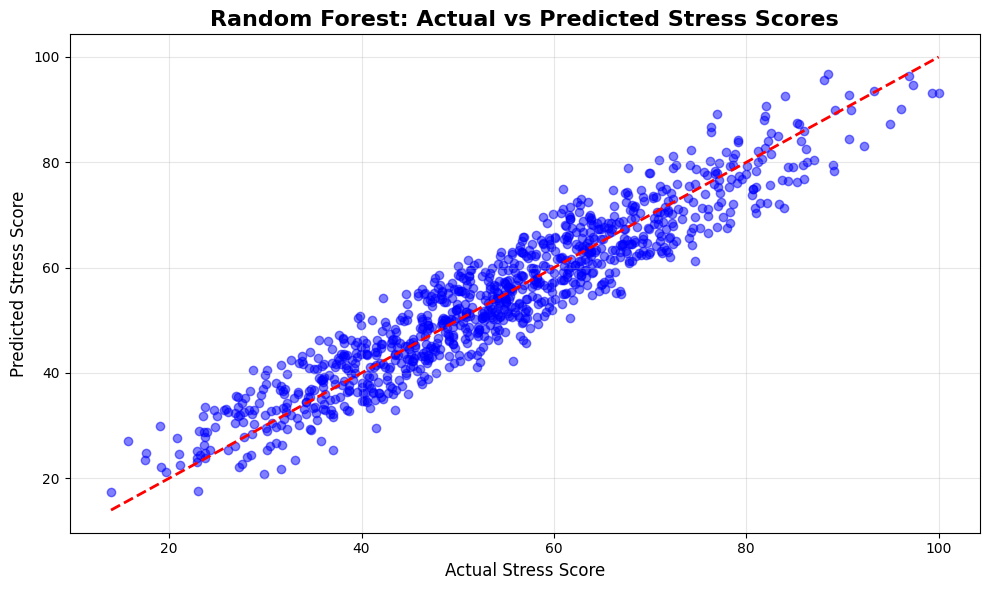

In [74]:
# Visualize predictions vs actual values for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Stress Score', fontsize=12)
plt.ylabel('Predicted Stress Score', fontsize=12)
plt.title('Random Forest: Actual vs Predicted Stress Scores', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

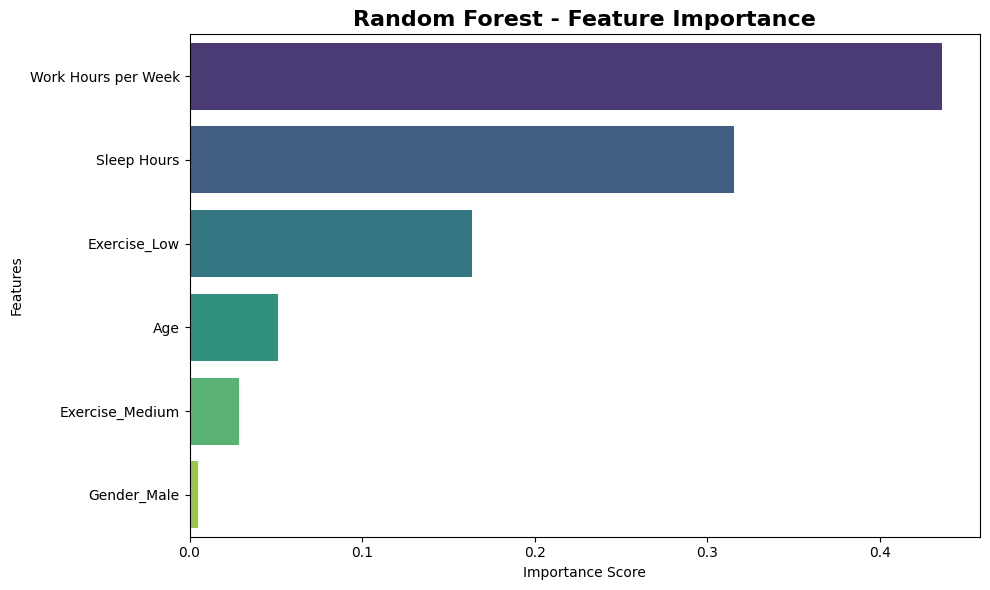


Feature Importance:
               Feature  Importance
2  Work Hours per Week    0.436214
1          Sleep Hours    0.315278
4         Exercise_Low    0.163539
0                  Age    0.051031
5      Exercise_Medium    0.028904
3          Gender_Male    0.005033


In [75]:
# Feature importance for Random Forest
rf_model = rf_pipeline.named_steps['regressor']
feature_names = (numerical_features +
                 [f"Gender_{cat}" for cat in rf_pipeline.named_steps['preprocessor']
                  .named_transformers_['cat'].categories_[0][1:]] +
                 [f"Exercise_{cat}" for cat in rf_pipeline.named_steps['preprocessor']
                  .named_transformers_['cat'].categories_[1][1:]])

importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Random Forest - Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(feature_importance_df)

## 7. Train XGBoost Model

In [76]:
# Create XGBoost Regressor pipeline
from xgboost import XGBRegressor

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, n_estimators=100,
                               learning_rate=0.1, max_depth=5))
])

print("Training XGBoost Regressor model...")
xgb_pipeline.fit(X_train, y_train)
print("XGBoost model trained successfully!")

# Make predictions
y_pred_xgb = xgb_pipeline.predict(X_test)

# Evaluate model
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"\nXGBoost Regression Metrics:")
print(f"  Mean Absolute Error (MAE): {xgb_mae:.4f}")
print(f"  Root Mean Squared Error (RMSE): {xgb_rmse:.4f}")
print(f"  R² Score: {xgb_r2:.4f}")

Training XGBoost Regressor model...
XGBoost model trained successfully!

XGBoost Regression Metrics:
  Mean Absolute Error (MAE): 3.9714
  Root Mean Squared Error (RMSE): 4.7219
  R² Score: 0.9078


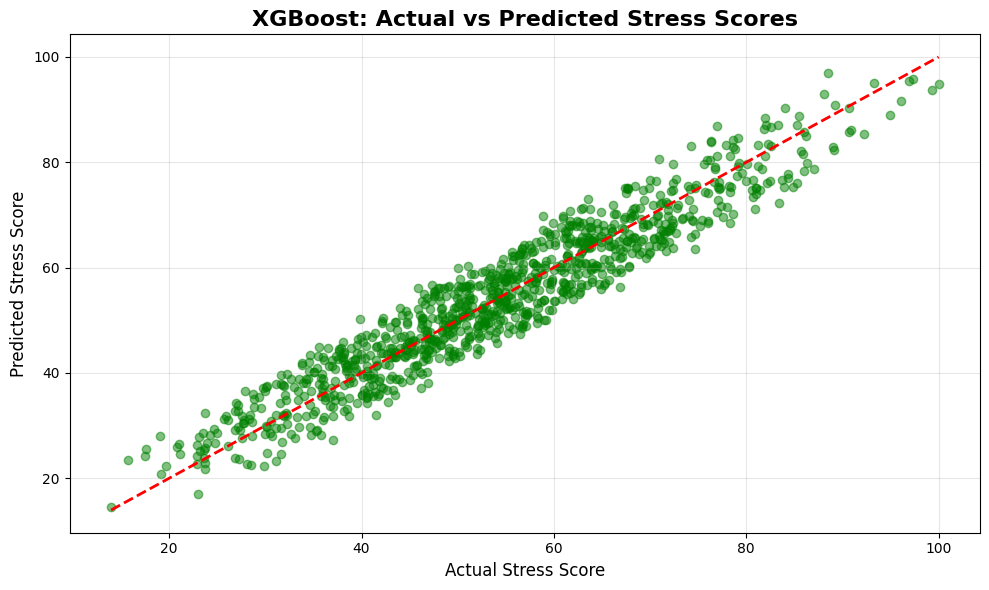

In [77]:
# Visualize predictions vs actual values for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Stress Score', fontsize=12)
plt.ylabel('Predicted Stress Score', fontsize=12)
plt.title('XGBoost: Actual vs Predicted Stress Scores', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

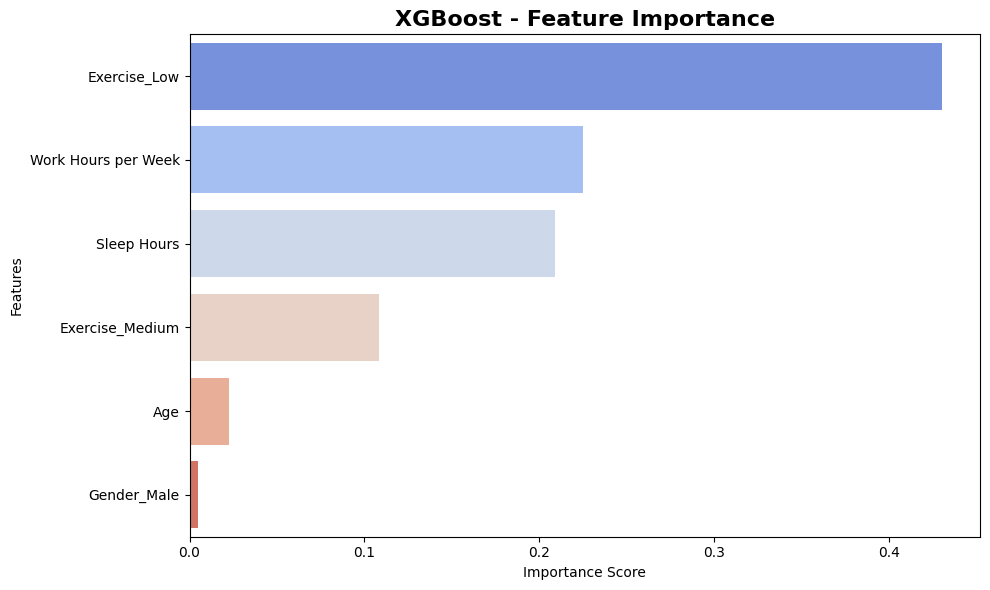


Feature Importance:
               Feature  Importance
4         Exercise_Low    0.430443
2  Work Hours per Week    0.225153
1          Sleep Hours    0.209081
5      Exercise_Medium    0.108155
0                  Age    0.022538
3          Gender_Male    0.004629


In [78]:
# Feature importance for XGBoost
xgb_model = xgb_pipeline.named_steps['regressor']
importances_xgb = xgb_model.feature_importances_

feature_importance_xgb_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_xgb
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_xgb_df, x='Importance', y='Feature', palette='coolwarm')
plt.title('XGBoost - Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(feature_importance_xgb_df)

## 8. Model Comparison

Model Comparison:
           Model       MAE      RMSE  R² Score
0  Random Forest  4.344183  5.245081  0.886297
1        XGBoost  3.971395  4.721889  0.907850


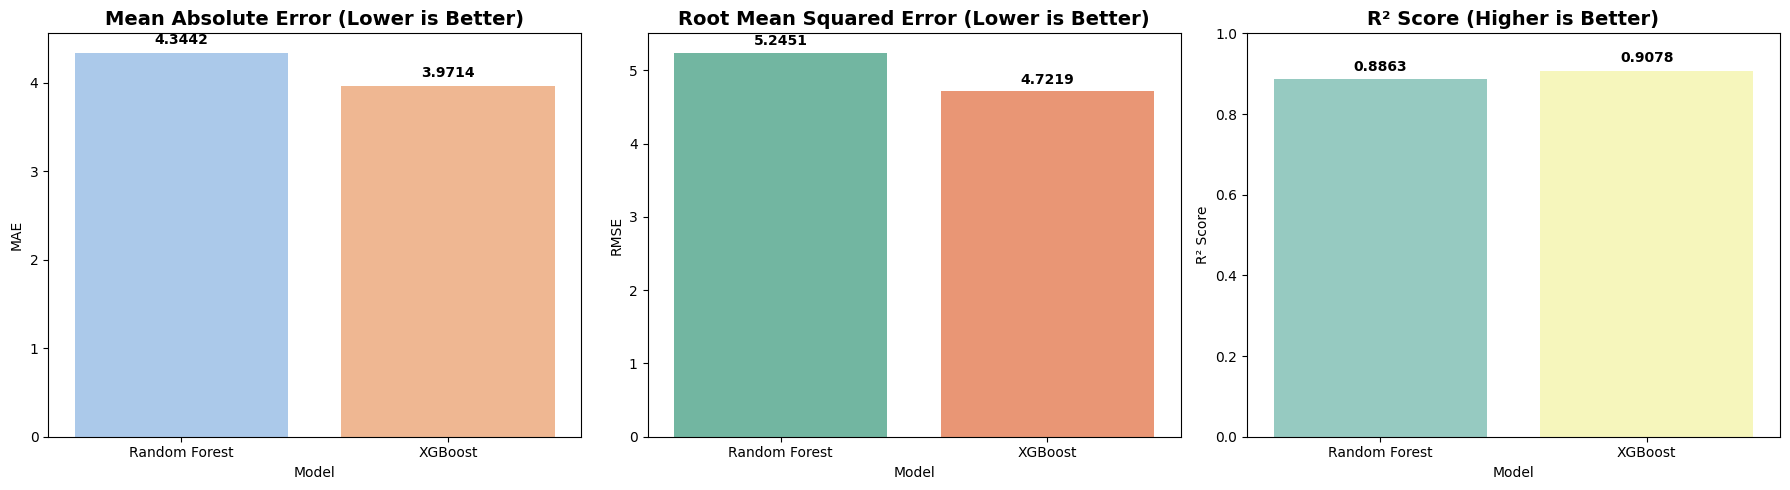

In [79]:
# Compare model performance
models_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'MAE': [rf_mae, xgb_mae],
    'RMSE': [rf_rmse, xgb_rmse],
    'R² Score': [rf_r2, xgb_r2]
})

print("Model Comparison:")
print(models_comparison)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE comparison
sns.barplot(data=models_comparison, x='Model', y='MAE', palette='pastel', ax=axes[0])
axes[0].set_title('Mean Absolute Error (Lower is Better)', fontsize=14, fontweight='bold')
for i, v in enumerate(models_comparison['MAE']):
    axes[0].text(i, v + 0.1, f'{v:.4f}', ha='center', fontweight='bold')

# RMSE comparison
sns.barplot(data=models_comparison, x='Model', y='RMSE', palette='Set2', ax=axes[1])
axes[1].set_title('Root Mean Squared Error (Lower is Better)', fontsize=14, fontweight='bold')
for i, v in enumerate(models_comparison['RMSE']):
    axes[1].text(i, v + 0.1, f'{v:.4f}', ha='center', fontweight='bold')

# R² Score comparison
sns.barplot(data=models_comparison, x='Model', y='R² Score', palette='Set3', ax=axes[2])
axes[2].set_title('R² Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[2].set_ylim(0, 1)
for i, v in enumerate(models_comparison['R² Score']):
    axes[2].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Select Best Model and Save

In [80]:
# Select the best model based on R² score (higher is better)
if rf_r2 >= xgb_r2:
    best_model = rf_pipeline
    best_model_name = "Random Forest"
    best_r2 = rf_r2
    best_mae = rf_mae
    best_rmse = rf_rmse
else:
    best_model = xgb_pipeline
    best_model_name = "XGBoost"
    best_r2 = xgb_r2
    best_mae = xgb_mae
    best_rmse = xgb_rmse

print(f"Best Model: {best_model_name}")
print(f"R² Score: {best_r2:.4f}")
print(f"MAE: {best_mae:.4f}")
print(f"RMSE: {best_rmse:.4f}")

Best Model: XGBoost
R² Score: 0.9078
MAE: 3.9714
RMSE: 4.7219


In [81]:
# Save the best model
model_filename = 'stress_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)

print(f"\nModel saved successfully as '{model_filename}'")
print(f"Model type: {best_model_name} Regressor")
print(f"R² Score: {best_r2:.4f}")
print(f"Mean Absolute Error: {best_mae:.4f}")


Model saved successfully as 'stress_model.pkl'
Model type: XGBoost Regressor
R² Score: 0.9078
Mean Absolute Error: 3.9714


## 10. Test the Saved Model

In [82]:
# Load the saved model
with open(model_filename, 'rb') as f:
    loaded_model = pickle.load(f)

print("Model loaded successfully!")

# Test with sample data
test_samples = pd.DataFrame([
    {'Age': 23, 'Gender': 'Male', 'Exercise Level': 'Medium', 'Sleep Hours': 7.0, 'Work Hours per Week': 45.0},
    {'Age': 45, 'Gender': 'Female', 'Exercise Level': 'Low', 'Sleep Hours': 5.0, 'Work Hours per Week': 65.0},
    {'Age': 30, 'Gender': 'Male', 'Exercise Level': 'High', 'Sleep Hours': 8.5, 'Work Hours per Week': 35.0},
    {'Age': 55, 'Gender': 'Female', 'Exercise Level': 'Medium', 'Sleep Hours': 6.0, 'Work Hours per Week': 50.0},
])

predictions = loaded_model.predict(test_samples)

print("\nTest Predictions:")
for i, (idx, row) in enumerate(test_samples.iterrows()):
    print(f"\nSample {i+1}:")
    print(f"  Age: {row['Age']}, Gender: {row['Gender']}, Exercise: {row['Exercise Level']}")
    print(f"  Sleep: {row['Sleep Hours']}h, Work: {row['Work Hours per Week']}h/week")
    print(f"  → Predicted Stress Score: {predictions[i]:.2f}/100")

Model loaded successfully!

Test Predictions:

Sample 1:
  Age: 23, Gender: Male, Exercise: Medium
  Sleep: 7.0h, Work: 45.0h/week
  → Predicted Stress Score: 47.44/100

Sample 2:
  Age: 45, Gender: Female, Exercise: Low
  Sleep: 5.0h, Work: 65.0h/week
  → Predicted Stress Score: 85.60/100

Sample 3:
  Age: 30, Gender: Male, Exercise: High
  Sleep: 8.5h, Work: 35.0h/week
  → Predicted Stress Score: 29.00/100

Sample 4:
  Age: 55, Gender: Female, Exercise: Medium
  Sleep: 6.0h, Work: 50.0h/week
  → Predicted Stress Score: 59.59/100


## 11. Save Dataset (Optional)

In [83]:
# Save the generated dataset
dataset_filename = 'stress_detection_dataset.csv'
df.to_csv(dataset_filename, index=False)
print(f"Dataset saved as '{dataset_filename}'")

Dataset saved as 'stress_detection_dataset.csv'


## 12. Download Files for Local Use

In [84]:
try:
    from google.colab import files
    print("Downloading model file...")
    files.download(model_filename)
    print("Downloading dataset file...")
    files.download(dataset_filename)
    print("Files downloaded successfully!")
except ImportError:
    print("Not running in Google Colab. Files are saved locally.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Files downloaded successfully!
